In [ ]:
"""
Target:
We try to achieve 99.4 test accuracy within 8k params.
We do this by experimenting with LR schedulers.


Result:
OneCycleLR and ExponentialLR were tried out.
Various params of OneCycleLR were tried.

num params: 8k
train accuracy: 99.17
test accuracy: > 99.35

A stable test accuracy of > 99.35 was achieved

Analysis:
Good LR scheduling can improve accuracy towards the end.


"""




In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch.optim.lr_scheduler import StepLR, OneCycleLR
import matplotlib.pyplot as plt

In [ ]:
%pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    train_loss /= len(train_loader.dataset)

    print('\n#Train set: Average loss: {:.4f}, Accuracy: {:.2f}%'.format(
        train_loss,
        100. * correct / len(train_loader.dataset)))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('#Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f'device: {device}')

torch.manual_seed(1)
batch_size = 128
lr=0.01

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7, 7), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

print(f'Num images in train: {len(train_loader.dataset)}')

device: cuda
Num images in train: 60000


In [ ]:
# from Step 2. Increase params to 8k. Use OneCycleLR scheduler.

class Net_17(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 3, padding=0)   #input - 28, Output 26, RF
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(12, 12, 3, padding=0)   #input - 26, Output 24, RF
        self.bn2 = nn.BatchNorm2d(12)

        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(12, 16, 3, padding=0)   #input - 24, Output 22, RF
        self.bn3 = nn.BatchNorm2d(16)

        self.conv4 = nn.Conv2d(16, 16, 3, padding=0) #input - 11, Output 9, RF
        self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.Conv2d(16, 15, 3, padding=0) #input - 9, Output 7, RF

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.conv6 = nn.Conv2d(15, 10, 1)            #input - 7, Output 7, RF

        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)
        self.dropout4 = nn.Dropout(0.1)
        self.dropout5 = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)

        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout3(x)



        x = F.relu(self.bn4(self.conv4(x)))
        x = self.dropout4(x)

        x = F.relu(self.conv5(x))
        x = self.gap(x)
        x = self.conv6(x)

        x = x.view(-1, 10)
        return F.log_softmax(x)

Net = Net_17

lr = 0.1

oclr_max_lr = 0.1
num_epochs = 15

model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)
# scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = OneCycleLR(optimizer, max_lr=oclr_max_lr, steps_per_epoch=1, epochs=num_epochs)

summary(model, input_size=(1, 28, 28))



##### For 20 epochs #######

#epoch: 16
#lr: 0.0188258346050237
#Train set: Average loss: 0.0002, Accuracy: 99.12%
#Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

#epoch: 17
#lr: 0.010908782242895003
#Train set: Average loss: 0.0002, Accuracy: 99.17%
#Test set: Average loss: 0.0186, Accuracy: 9944/10000 (99.44%)

#epoch: 18
#lr: 0.004951936798652629
#Train set: Average loss: 0.0002, Accuracy: 99.23%
#Test set: Average loss: 0.0179, Accuracy: 9946/10000 (99.46%)

#epoch: 19
#lr: 0.0012539993764912555
#Train set: Average loss: 0.0002, Accuracy: 99.24%
#Test set: Average loss: 0.0175, Accuracy: 9949/10000 (99.49%)

#epoch: 20
#lr: 4e-07
#Train set: Average loss: 0.0002, Accuracy: 99.28%
#Test set: Average loss: 0.0177, Accuracy: 9951/10000 (99.51%)


############  For 15 epochs ##########


#epoch: 11
#lr: 0.03173322184988512
#Train set: Average loss: 0.0003, Accuracy: 98.98%
#Test set: Average loss: 0.0212, Accuracy: 9931/10000 (99.31%)

#epoch: 12
#lr: 0.0188258346050237
#Train set: Average loss: 0.0002, Accuracy: 99.06%
#Test set: Average loss: 0.0218, Accuracy: 9929/10000 (99.29%)

#epoch: 13
#lr: 0.008688426531955128
#Train set: Average loss: 0.0002, Accuracy: 99.08%
#Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99.38%)

#epoch: 14
#lr: 0.002221750825254118
#Train set: Average loss: 0.0002, Accuracy: 99.16%
#Test set: Average loss: 0.0191, Accuracy: 9942/10000 (99.42%)

#epoch: 15
#lr: 4e-07
#Train set: Average loss: 0.0002, Accuracy: 99.23%
#Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
           Dropout-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]           1,308
       BatchNorm2d-5           [-1, 12, 24, 24]              24
           Dropout-6           [-1, 12, 24, 24]               0
         MaxPool2d-7           [-1, 12, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           1,744
       BatchNorm2d-9           [-1, 16, 10, 10]              32
          Dropout-10           [-1, 16, 10, 10]               0
           Conv2d-11             [-1, 16, 8, 8]           2,320
      BatchNorm2d-12             [-1, 16, 8, 8]              32
          Dropout-13             [-1, 16, 8, 8]               0
           Conv2d-14             [-1, 1

<ipython-input-17-89d19ebaed0e>:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
# Try ExponentialLR

lr = 0.1

oclr_max_lr = 0.1
num_epochs = 15

model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)
# scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
# scheduler = OneCycleLR(optimizer, max_lr=oclr_max_lr, steps_per_epoch=1, epochs=num_epochs)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)

summary(model, input_size=(1, 28, 28))



#epoch: 13
#lr: 0.0013841287200999988
#Train set: Average loss: 0.0005, Accuracy: 98.27%
#Test set: Average loss: 0.0442, Accuracy: 9868/10000 (98.68%)

#epoch: 14
#lr: 0.0009688901040699991
#Train set: Average loss: 0.0005, Accuracy: 98.14%
#Test set: Average loss: 0.0454, Accuracy: 9865/10000 (98.65%)

#epoch: 15
#lr: 0.0006782230728489993
#Train set: Average loss: 0.0005, Accuracy: 98.19%
#Test set: Average loss: 0.0434, Accuracy: 9869/10000 (98.69%)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
           Dropout-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]           1,308
       BatchNorm2d-5           [-1, 12, 24, 24]              24
           Dropout-6           [-1, 12, 24, 24]               0
         MaxPool2d-7           [-1, 12, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           1,744
       BatchNorm2d-9           [-1, 16, 10, 10]              32
          Dropout-10           [-1, 16, 10, 10]               0
           Conv2d-11             [-1, 16, 8, 8]           2,320
      BatchNorm2d-12             [-1, 16, 8, 8]              32
          Dropout-13             [-1, 16, 8, 8]               0
           Conv2d-14             [-1, 1

<ipython-input-17-89d19ebaed0e>:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
Net = Net_17

lr = 0.1

oclr_max_lr = 0.1
num_epochs = 15

model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)
# scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = OneCycleLR(optimizer, max_lr=oclr_max_lr, steps_per_epoch=1, epochs=num_epochs, pct_start=0.2)

summary(model, input_size=(1, 28, 28))




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
           Dropout-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]           1,308
       BatchNorm2d-5           [-1, 12, 24, 24]              24
           Dropout-6           [-1, 12, 24, 24]               0
         MaxPool2d-7           [-1, 12, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           1,744
       BatchNorm2d-9           [-1, 16, 10, 10]              32
          Dropout-10           [-1, 16, 10, 10]               0
           Conv2d-11             [-1, 16, 8, 8]           2,320
      BatchNorm2d-12             [-1, 16, 8, 8]              32
          Dropout-13             [-1, 16, 8, 8]               0
           Conv2d-14             [-1, 1

<ipython-input-17-89d19ebaed0e>:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
# model = torch.nn.Linear(2, 1)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)
# lrs = []


# for i in range(15):
#     optimizer.step()
#     lrs.append(optimizer.param_groups[0]["lr"])
#     print("lr: ", optimizer.param_groups[0]["lr"])
#     scheduler.step()

# plt.plot(lrs)

In [ ]:
Net = Net_17

lr = 0.1

oclr_max_lr = 0.1
num_epochs = 15

model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = OneCycleLR(optimizer, max_lr=oclr_max_lr, steps_per_epoch=1,
                       epochs=num_epochs, pct_start=0.3)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
           Dropout-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]           1,308
       BatchNorm2d-5           [-1, 12, 24, 24]              24
           Dropout-6           [-1, 12, 24, 24]               0
         MaxPool2d-7           [-1, 12, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           1,744
       BatchNorm2d-9           [-1, 16, 10, 10]              32
          Dropout-10           [-1, 16, 10, 10]               0
           Conv2d-11             [-1, 16, 8, 8]           2,320
      BatchNorm2d-12             [-1, 16, 8, 8]              32
          Dropout-13             [-1, 16, 8, 8]               0
           Conv2d-14             [-1, 1

<ipython-input-17-89d19ebaed0e>:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


#epoch: 1
#lr: 0.0040000000000000036


  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-17-89d19ebaed0e>:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=0.17490625381469727 batch_id=468: 100%|██████████| 469/469 [00:33<00:00, 13.92it/s]


#Train set: Average loss: 0.0080, Accuracy: 65.27%


#Test set: Average loss: 0.2518, Accuracy: 9222/10000 (92.22%)

#epoch: 2
#lr: 0.022072489510780793


loss=0.0644674226641655 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.53it/s]


#Train set: Average loss: 0.0013, Accuracy: 95.00%


#Test set: Average loss: 0.0639, Accuracy: 9810/10000 (98.10%)

#epoch: 3
#lr: 0.0626810048299031


loss=0.11920801550149918 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.13it/s]


#Train set: Average loss: 0.0008, Accuracy: 96.95%


#Test set: Average loss: 0.0639, Accuracy: 9783/10000 (97.83%)

#epoch: 4
#lr: 0.09524650565931612


loss=0.05484486743807793 batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.56it/s]


#Train set: Average loss: 0.0006, Accuracy: 97.63%


#Test set: Average loss: 0.0411, Accuracy: 9884/10000 (98.84%)

#epoch: 5
#lr: 0.09944154354509119


loss=0.07897200435400009 batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 17.59it/s]


#Train set: Average loss: 0.0005, Accuracy: 98.08%


#Test set: Average loss: 0.0310, Accuracy: 9907/10000 (99.07%)

#epoch: 6
#lr: 0.09504846320134738


loss=0.030147211626172066 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.23it/s]


#Train set: Average loss: 0.0004, Accuracy: 98.33%


#Test set: Average loss: 0.0351, Accuracy: 9896/10000 (98.96%)

#epoch: 7
#lr: 0.08665264698111695


loss=0.05822373926639557 batch_id=468: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]


#Train set: Average loss: 0.0004, Accuracy: 98.40%


#Test set: Average loss: 0.0317, Accuracy: 9904/10000 (99.04%)

#epoch: 8
#lr: 0.0750001


loss=0.058729302138090134 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.76it/s]


#Train set: Average loss: 0.0004, Accuracy: 98.50%


#Test set: Average loss: 0.0329, Accuracy: 9903/10000 (99.03%)

#epoch: 9
#lr: 0.06112620219362893


loss=0.025506997480988503 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.20it/s]


#Train set: Average loss: 0.0003, Accuracy: 98.69%


#Test set: Average loss: 0.0329, Accuracy: 9900/10000 (99.00%)

#epoch: 10
#lr: 0.046263710266697504


loss=0.06617381423711777 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.60it/s]


#Train set: Average loss: 0.0003, Accuracy: 98.78%


#Test set: Average loss: 0.0258, Accuracy: 9919/10000 (99.19%)

#epoch: 11
#lr: 0.03173322184988512


loss=0.0950298085808754 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.67it/s]


#Train set: Average loss: 0.0003, Accuracy: 98.84%


#Test set: Average loss: 0.0222, Accuracy: 9927/10000 (99.27%)

#epoch: 12
#lr: 0.0188258346050237


loss=0.017018385231494904 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.66it/s]


#Train set: Average loss: 0.0002, Accuracy: 99.01%


#Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

#epoch: 13
#lr: 0.008688426531955128


loss=0.014849289320409298 batch_id=468: 100%|██████████| 469/469 [00:24<00:00, 18.78it/s]


#Train set: Average loss: 0.0002, Accuracy: 99.01%


#Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

#epoch: 14
#lr: 0.002221750825254118


loss=0.05150482431054115 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.58it/s]


#Train set: Average loss: 0.0002, Accuracy: 99.12%


#Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

#epoch: 15
#lr: 4e-07


loss=0.019408313557505608 batch_id=468: 100%|██████████| 469/469 [00:25<00:00, 18.37it/s]


#Train set: Average loss: 0.0002, Accuracy: 99.15%


#Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)



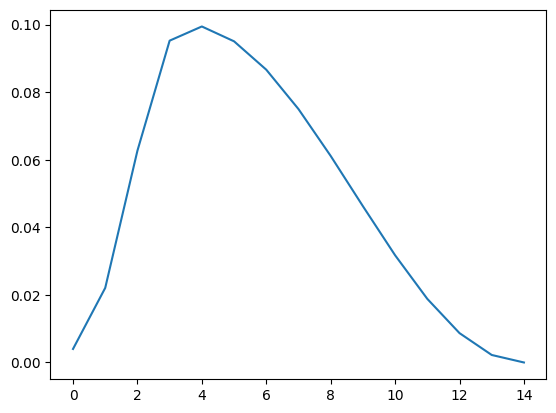

In [ ]:
lrs = []
for epoch in range(1, num_epochs+1):
    print(f'#epoch: {epoch}')
    print(f'#lr: {optimizer.param_groups[0]["lr"]}')
    lrs.append(optimizer.param_groups[0]["lr"])
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

    scheduler.step()

plt.plot(lrs)